In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
import cv2
import shutil


In [3]:
data = "../input/covid-19-x-ray-10000-images/dataset"
covid = "../input/covid-19-x-ray-10000-images/dataset/covid"
normal = "../input/covid-19-x-ray-10000-images/dataset/normal"

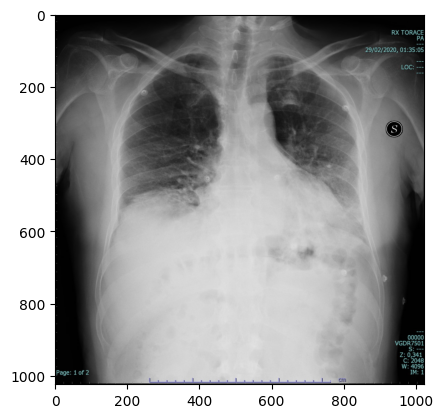

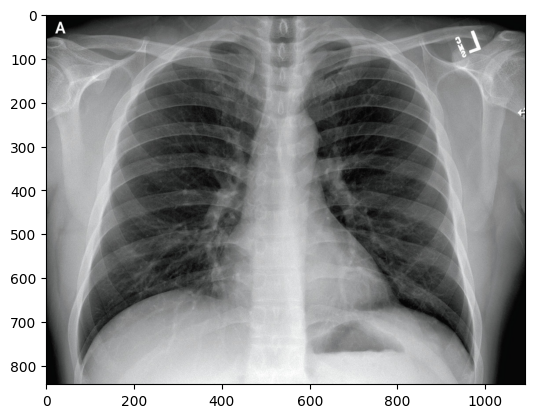

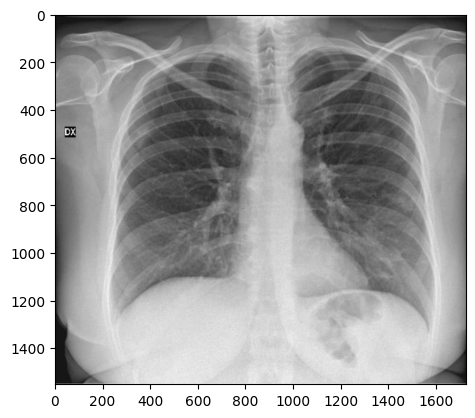

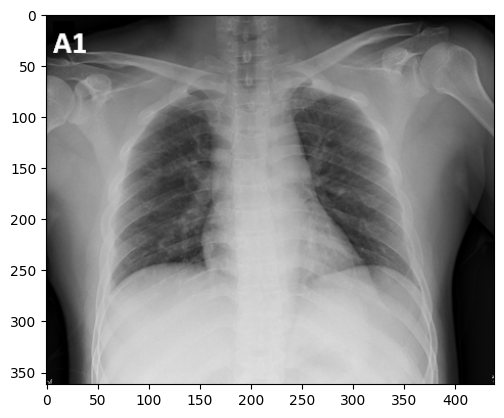

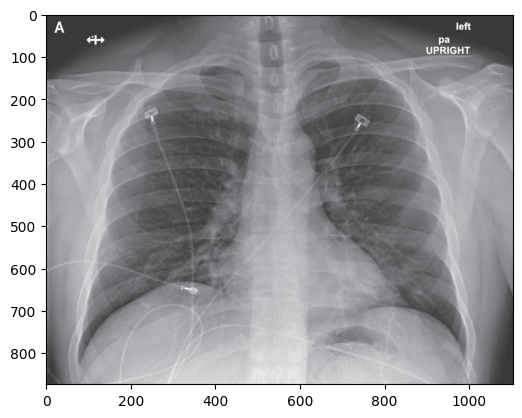

In [4]:
#visualize covid images
for images in os.listdir(covid)[0:5]:
    
    img = image.load_img(covid+"//"+images)
    plt.imshow(img)
    plt.show()

In [5]:
print(f"number of covid images : {len(covid)}")
print(f"number of normal images : {len(normal)}")

number of covid images : 50
number of normal images : 51


In [14]:
train_datagen = ImageDataGenerator(rescale = 1/255, rotation_range = 0.3, zoom_range = 0.3, 
                                  horizontal_flip=True,vertical_flip=True,fill_mode='nearest',
                                   validation_split=0.25)
train_gen = train_datagen.flow_from_directory(data, target_size = (200,200),
                                             batch_size = 6, class_mode = 'binary', 
                                              subset= 'training')
valid_gen = train_datagen.flow_from_directory(data, target_size = (200,200),
                                             batch_size = 6, class_mode = 'binary', 
                                              subset= 'validation')

Found 74 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [7]:
train_gen.class_indices

{'covid': 0, 'normal': 1}

In [8]:
#using ResNet50
INPUT_SHAPE = (200,200,3) 

#get the pretrained model
base_model = tf.keras.applications.Xception(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 99, 99,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 99, 99,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 99, 99,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 97, 97,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 97, 97,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 97, 97,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 97, 97,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 97, 97,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 97, 97,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 97, 97,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 97, 97,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 49, 49,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 49, 49,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 49, 49,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 49,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 49, 49,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
from tensorflow.keras.layers import Input

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(250, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 198, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 97, 97, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 44, 44, 250)    │       144,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 44, 44, 250)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 128)    │       288,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 21, 21, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 19, 19, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 9, 9, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1)              │             

 Total params: 759,419 (2.90 MB)

 Trainable params: 759,419 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_gen,validation_data=valid_gen,epochs=60)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - accuracy: 0.9350 - loss: 0.1931 - val_accuracy: 0.8333 - val_loss: 0.2737
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 614ms/step - accuracy: 0.9161 - loss: 0.2356 - val_accuracy: 0.9167 - val_loss: 0.2491
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 656ms/step - accuracy: 0.8894 - loss: 0.3381 - val_accuracy: 0.8333 - val_loss: 0.2061
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 607ms/step - accuracy: 0.9538 - loss: 0.2242 - val_accuracy: 0.9167 - val_loss: 0.3704
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 631ms/step - accuracy: 0.7966 - loss: 0.3407 - val_accuracy: 0.8750 - val_loss: 0.3067
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 639ms/step - accuracy: 0.8819 - loss: 0.2845 - val_accuracy: 0.7500 - val_loss: 0.3883
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 608ms/step - accuracy: 0.8761 - loss: 0.3585 - val_accuracy: 0.8750 - val_loss: 0.2401
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 602ms/step - accuracy: 0.9685 - loss: 0.1219 - val_accurac

In [22]:
print("training_accuracy",history.history["accuracy"][-1])
print("validation_accuracy",history.history["val_accuracy"][-1])

training_accuracy 0.9324324131011963
validation_accuracy 0.9166666865348816


In [23]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

predictions = (model.predict(valid_gen)>0.5).astype("int32")

y_test2 = valid_gen.labels
print('Classification report:\n', classification_report(y_test2, predictions))
print('Accuracy score:\n', accuracy_score(y_test2, predictions))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.71      0.67        17
           1       0.00      0.00      0.00         7

    accuracy                           0.50        24
   macro avg       0.32      0.35      0.33        24
weighted avg       0.45      0.50      0.47        24

Accuracy score:
 0.5


In [20]:
valid_gen.class_indices

{'covid': 0, 'normal': 1}

In [28]:
label = valid_gen.classes
predict = model.predict(valid_gen)
predicted_class=np.argmax(predict,axis=1)
labels = (valid_gen.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class]
print(predicted_class)
print (labels)
print (predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'covid': 0, 'normal': 1}
['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid']


In [29]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class,label)
cf

array([[17,  7],
       [ 0,  0]])

In [30]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,All
Actual,,
0,17,17
1,7,7
All,24,24


<Axes: >

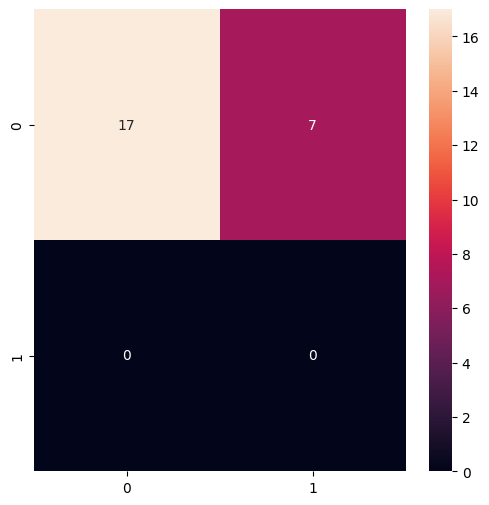

In [31]:
import seaborn as sns
plt.figure(figsize = (6,6))
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(predicted_class,label)
sns.heatmap(cf, linecolor = 'black' , annot = True, fmt='')